# Mini-MobileNetV2: Emotion Recognition 

- Project: Music Recommendation System Using Real-Time Emotion 
- DetectionModel: MobileEmotionNet (Custom architecture inspired by MobileNetV2)
- Task: 5-class emotion classification (Angry, Happy, Sad, Surprise, Neutral)
- Dataset: FER-2013 (preprocessed to 224×224 RGB)


### Import Dependencies

In [ ]:
import os, json, time, shutil
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
tf.keras.utils.set_random_seed(SEED)
try: tf.config.experimental.enable_op_determinism()
except: pass

# --- EDIT ONLY if your dataset slug changes ---
DATASET_ROOT = Path("/kaggle/input/fer2013-preprocessed-new/fer2013_processed_new")
OUT_DIR = Path("/kaggle/working/output_minimnv2")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATASET_ROOT:", DATASET_ROOT)
print("OUT_DIR:", OUT_DIR)

# GPU: memory growth + mixed precision when available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        try: tf.config.experimental.set_memory_growth(g, True)
        except: pass
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
        print("GPU found. Mixed precision enabled.")
    except Exception as e:
        print("Mixed precision note:", e)
else:
    print("No GPU detected — running on CPU.")


2025-11-05 08:09:31.477585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762330171.501773      89 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762330171.508845      89 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DATASET_ROOT: /kaggle/input/fer2013-preprocessed-new/fer2013_processed_new
OUT_DIR: /kaggle/working/output_minimnv2
GPU found. Mixed precision enabled.


### Load CSVs

In [ ]:
def load_split(root: Path, name: str) -> pd.DataFrame:
    csv_path = root / f"{name}.csv"
    assert csv_path.exists(), f"{csv_path} not found"
    df = pd.read_csv(csv_path)
    df = df.rename(columns={"emotion":"label", "class":"label", "path":"filepath"})
    assert {"filepath","label"}.issubset(df.columns), f"{name}.csv must contain 'filepath' and 'label/emotion'"
    df["filepath"] = (
        df["filepath"].astype(str)
        .str.replace("\\", "/", regex=False)
        .str.replace(r"/+", "/", regex=True)
        .str.lstrip("/")
    )
    df["split"] = name
    return df[["split","label","filepath"]]

train_df = load_split(DATASET_ROOT, "train")
val_df   = load_split(DATASET_ROOT, "val")
test_df  = load_split(DATASET_ROOT, "test")
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Resolve to absolute paths under DATASET_ROOT
def to_abs(p: str) -> str:
    return (DATASET_ROOT / p).resolve().as_posix()
df["filepath"] = df["filepath"].apply(to_abs)

# Sanity check (should be 0)
missing = [p for p in df["filepath"] if not Path(p).exists()]
print(f"Missing files: {len(missing)}")
if missing[:5]:
    print("First few missing:\n", "\n".join(missing[:5]))

# Labels & ids
classes  = sorted(df["label"].unique().tolist())
class2id = {c:i for i,c in enumerate(classes)}
id2class = {i:c for c,i in class2id.items()}
df["label_id"] = df["label"].map(class2id).astype(int)
NUM_CLASSES = len(classes)

# Splits
train_df = df[df["split"]=="train"].reset_index(drop=True)
val_df   = df[df["split"]=="val"].reset_index(drop=True)
test_df  = df[df["split"]=="test"].reset_index(drop=True)

# Class weights (inverse frequency on train)
counts = Counter(train_df["label_id"].tolist()); total = sum(counts.values())
class_weights = {i: total/(NUM_CLASSES*counts.get(i,1)) for i in range(NUM_CLASSES)}

print("Classes:", classes)
print(f"Counts → train:{len(train_df)}  val:{len(val_df)}  test:{len(test_df)}")
print("Class weights:", class_weights)


Missing files: 0
Classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']
Counts → train:21758  val:2418  test:6043
Class weights: {0: 1.2101223581757508, 1: 0.6701986754966888, 2: 0.9739480752014325, 3: 1.001058201058201, 4: 1.5247372109320252}


### tf.data input pipeline

In [ ]:
IMG_SIZE   = 160          # <-- as requested
BATCH_SIZE = 32 if tf.config.list_physical_devices("GPU") else 32
AUTOTUNE   = tf.data.AUTOTUNE

def decode_and_resize(path: tf.Tensor) -> tf.Tensor:
    x = tf.io.read_file(path)
    x = tf.io.decode_image(x, channels=3, expand_animations=False)
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method="bicubic")
    x = tf.clip_by_value(x, 0, 255)
    return tf.cast(x, tf.float32) / 255.0

@tf.function
def make_example(path, label_id):
    return decode_and_resize(path), tf.cast(label_id, tf.int32)

augmenter = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.10),
], name="augment")

def make_ds(frame: pd.DataFrame, shuffle: bool, aug: bool) -> tf.data.Dataset:
    paths  = frame["filepath"].astype(str).tolist()
    labels = frame["label_id"].astype(int).tolist()
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(make_example, num_parallel_calls=AUTOTUNE)
    if aug:
        ds = ds.map(lambda x,y: (augmenter(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

def to_one_hot(ds: tf.data.Dataset, n: int) -> tf.data.Dataset:
    return ds.map(lambda x,y: (x, tf.one_hot(y, n)), num_parallel_calls=AUTOTUNE)

train_ds = make_ds(train_df, shuffle=True,  aug=True)
val_ds   = make_ds(val_df,   shuffle=False, aug=False)
test_ds  = make_ds(test_df,  shuffle=False, aug=False)

_cache_id = str(int(time.time()))
train_ds = train_ds.cache(str(OUT_DIR / f"cache_train_{_cache_id}")).prefetch(AUTOTUNE)
val_ds   = val_ds  .cache(str(OUT_DIR / f"cache_val_{_cache_id}")).prefetch(AUTOTUNE)
test_ds  = test_ds .cache(str(OUT_DIR / f"cache_test_{_cache_id}")).prefetch(AUTOTUNE)

train_ds_oh = to_one_hot(train_ds, NUM_CLASSES)
val_ds_oh   = to_one_hot(val_ds,   NUM_CLASSES)
test_ds_oh  = to_one_hot(test_ds,  NUM_CLASSES)


### Build Mini-MobileNetV2 

In [ ]:
L2_WEIGHT = 1e-4
ALPHA     = 0.75   # <-- width multiplier for speed

def relu6(x): 
    return layers.ReLU(max_value=6.0)(x)

def conv_bn_relu(x, filters, k, s, name):
    x = layers.Conv2D(
        filters, k, strides=s, padding="same", use_bias=False,
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT),
        name=f"{name}_conv"
    )(x)
    x = layers.BatchNormalization(name=f"{name}_bn")(x)
    return relu6(x)

def inverted_res_block(x, t, out_channels, stride, block_id):
    """MobileNetV2-style inverted residual with ReLU6, linear bottleneck."""
    in_ch = int(x.shape[-1]); pref = f"b{block_id}"
    # expand
    ex = x
    if t != 1:
        ex = layers.Conv2D(int(in_ch*t), 1, padding="same", use_bias=False,
                           kernel_regularizer=keras.regularizers.l2(L2_WEIGHT),
                           name=f"{pref}_exp")(ex)
        ex = layers.BatchNormalization(name=f"{pref}_exp_bn")(ex)
        ex = relu6(ex)
    # depthwise
    dw = layers.DepthwiseConv2D(3, strides=stride, padding="same", use_bias=False,
                                depthwise_regularizer=keras.regularizers.l2(L2_WEIGHT),
                                name=f"{pref}_dw")(ex)
    dw = layers.BatchNormalization(name=f"{pref}_dw_bn")(dw)
    dw = relu6(dw)
    # project (linear)
    pj = layers.Conv2D(out_channels, 1, padding="same", use_bias=False,
                       kernel_regularizer=keras.regularizers.l2(L2_WEIGHT),
                       name=f"{pref}_proj")(dw)
    pj = layers.BatchNormalization(name=f"{pref}_proj_bn")(pj)
    # residual if shape matches & no downsample
    if stride == 1 and in_ch == out_channels:
        return layers.Add(name=f"{pref}_add")([x, pj])
    return pj

def build_mini_mnv2(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES, alpha=ALPHA):
    """Mini MobileNetV2: t=4, fewer repeats, α=0.75, small head."""
    def C(c): return max(8, int(c * alpha))
    inp = keras.Input(shape=input_shape, name="input")
    # stem (downsample early, small channels)
    x = conv_bn_relu(inp, C(16), 3, 2, "stem")  # 160->80

    # stages: (t=4 here)
    cfg = [
        (1,  16, 1, 1),
        (4,  24, 1, 2),  # 80->40
        (4,  32, 2, 2),  # 40->20
        (4,  64, 2, 2),  # 20->10
        (4,  96, 2, 1),  # keep 10
        (4, 160, 1, 2),  # 10->5
        (4, 192, 1, 1),  # keep 5
    ]
    bid = 1
    for t,c,n,s in cfg:
        x = inverted_res_block(x, t, C(c), s, bid); bid += 1
        for _ in range(n-1):
            x = inverted_res_block(x, t, C(c), 1, bid); bid += 1

    # lightweight head
    head_ch = min(512, C(512))
    x = conv_bn_relu(x, head_ch, 1, 1, "head")
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(0.20, name="drop")(x)
    out = layers.Dense(num_classes, activation="softmax", dtype="float32", name="pred")(x)
    return keras.Model(inp, out, name=f"MiniMobileNetV2_a{alpha}_160")

model = build_mini_mnv2()
model.summary(line_length=120)


Model: "MiniMobileNetV2_a0.75_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input (InputLayer)                │ (None, 160, 160, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ cast (Cast)                       │ (None, 160, 160, 3)          │                 0 │ input[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_conv (Conv2D)                │ (None, 80, 80, 12)           │               324 │ cast[0][0]                
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_bn (BatchNormalization)      │ (None, 80, 80, 12)           │                48 │ stem_conv[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu (ReLU)                      │ (None, 80, 80, 12)           │                 0 │ stem_bn[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_dw (DepthwiseConv2D)           │ (None, 80, 80, 12)           │               108 │ re_lu[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_dw_bn (BatchNormalization)     │ (None, 80, 80, 12)           │                48 │ b1_dw[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_1 (ReLU)                    │ (None, 80, 80, 12)           │                 0 │ b1_dw_bn[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_proj (Conv2D)                  │ (None, 80, 80, 12)           │               144 │ re_lu_1[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_proj_bn (BatchNormalization)   │ (None, 80, 80, 12)           │                48 │ b1_proj[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_add (Add)                      │ (None, 80, 80, 12)           │                 0 │ re_lu[0][0], b1_proj_bn[0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_exp (Conv2D)                   │ (None, 80, 80, 48)           │               576 │ b1_add[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_exp_bn (BatchNormalization)    │ (None, 80, 80, 48)           │               192 │ b2_exp[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_2 (ReLU)                    │ (None, 80, 80, 48)           │                 0 │ b2_exp_bn[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_dw (DepthwiseConv2D)           │ (None, 40, 40, 48)           │               432 │ re_lu_2[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_dw_bn (BatchNormalization)     │ (None, 40, 40, 48)           │               192 │ b2_dw[0][0]               
├───────────────────────────────────┼───────────────────

 Total params: 372,485 (1.42 MB)

 Trainable params: 363,497 (1.39 MB)

 Non-trainable params: 8,988 (35.11 KB)

### Compile, train, save best

In [ ]:
NUM_EPOCHS   = 30
LABEL_SMOOTH = 0.05

optimizer = keras.optimizers.Adam(1e-3)
loss      = keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
metrics   = [
    keras.metrics.CategoricalAccuracy(name="accuracy"),
    keras.metrics.TopKCategoricalAccuracy(k=3, name="top3"),
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(OUT_DIR / "best_model.keras"),
        monitor="val_accuracy", mode="max",
        save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", mode="max",
        patience=5, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.CSVLogger(str(OUT_DIR / "history.csv")),
    keras.callbacks.TerminateOnNaN(),
]

history = model.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=NUM_EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("Best model saved at:", OUT_DIR / "best_model.keras")


Epoch 1/30


2025-11-05 08:12:14.406716: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_9}}
I0000 00:00:1762330360.169856     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.2510 - loss: 1.8063 - top3: 0.6658
Epoch 1: val_accuracy improved from -inf to 0.38213, saving model to /kaggle/working/output_minimnv2/best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 437s 602ms/step - accuracy: 0.2511 - loss: 1.8062 - top3: 0.6658 - val_accuracy: 0.3821 - val_loss: 1.6659 - val_top3: 0.7821
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.4163 - loss: 1.5780 - top3: 0.8045
Epoch 2: val_accuracy improved from 0.38213 to 0.46195, saving model to /kaggle/working/output_minimnv2/best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 331s 486ms/step - accuracy: 0.4163 - loss: 1.5779 - top3: 0.8045 - val_accuracy: 0.4620 - val_loss: 1.5397 - val_top3: 0.8337
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.5182 - loss: 1.4062 - top3: 0.8690
Epoch 3: val_accuracy improved from 0.46195 to 0.50041, saving model to /kaggle/working/output_minimnv2/best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 340

### Evaluate & export

Loaded best checkpoint: /kaggle/working/output_minimnv2/best_model.keras

Evaluating on test set...
Test metrics: {'accuracy': 0.6802912354469299, 'loss': 1.0380041599273682, 'top3': 0.9480390548706055}


2025-11-05 10:52:04.354466: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Artifacts zipped at: /kaggle/working/output_minimnv2.zip

Classification report:
               precision    recall  f1-score   support

       angry       0.58      0.60      0.59       958
       happy       0.86      0.81      0.83      1774
     neutral       0.54      0.67      0.60      1233
         sad       0.58      0.57      0.58      1247
    surprise       0.88      0.68      0.77       831

    accuracy                           0.68      6043
   macro avg       0.69      0.67      0.67      6043
weighted avg       0.70      0.68      0.68      6043

Confusion matrix:
 [[ 571   38  154  173   22]
 [  97 1434  136   76   31]
 [  94   72  831  226   10]
 [ 163   65  297  711   11]
 [  60   60  114   33  564]]


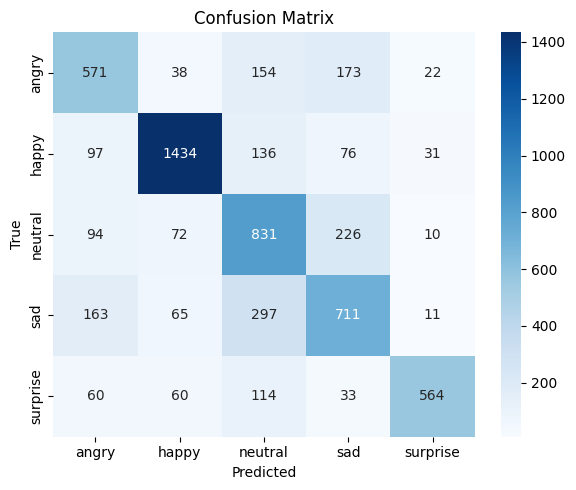

In [ ]:
best_path = OUT_DIR / "best_model.keras"
if best_path.exists():
    model = keras.models.load_model(best_path)
    print("Loaded best checkpoint:", best_path)
else:
    print("Best checkpoint not found; using current model in memory.")
    
print("\nEvaluating on test set...")
test_metrics = model.evaluate(test_ds_oh, verbose=0, return_dict=True)
print("Test metrics:", test_metrics)

# Predictions for detailed report
probs = np.concatenate([model.predict(x, verbose=0) for x,_ in test_ds_oh], axis=0)
y_pred = probs.argmax(axis=1)
y_true = test_df["label_id"].to_numpy()

from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_true, y_pred, target_names=[id2class[i] for i in range(NUM_CLASSES)])
cm     = confusion_matrix(y_true, y_pred)

# Save artifacts
with open(OUT_DIR / "classification_report.txt", "w", encoding="utf-8") as f:
    f.write(report)
np.savetxt(OUT_DIR / "confusion_matrix.csv", cm, fmt="%d", delimiter=",")

with open(OUT_DIR / "labels.json", "w", encoding="utf-8") as f:
    json.dump({"classes": classes, "class2id": class2id, "id2class": id2class}, f, indent=2)

# Zip outputs
zip_path = str(OUT_DIR) + ".zip"
try:
    if os.path.exists(zip_path):
        os.remove(zip_path)
    shutil.make_archive(str(OUT_DIR), "zip", OUT_DIR)
    print("Artifacts zipped at:", zip_path)
except Exception as e:
    print("Zip note:", e)

print("\nClassification report:\n", report)
print("Confusion matrix:\n", cm)

# Confusion matrix heatmap
try:
    import seaborn as sns, matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[id2class[i] for i in range(NUM_CLASSES)],
                yticklabels=[id2class[i] for i in range(NUM_CLASSES)])
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Heatmap skipped:", e)


### training curves (Loss, Accuracy, LR)

Saved curves to: /kaggle/working/output_minimnv2/training_curves.png


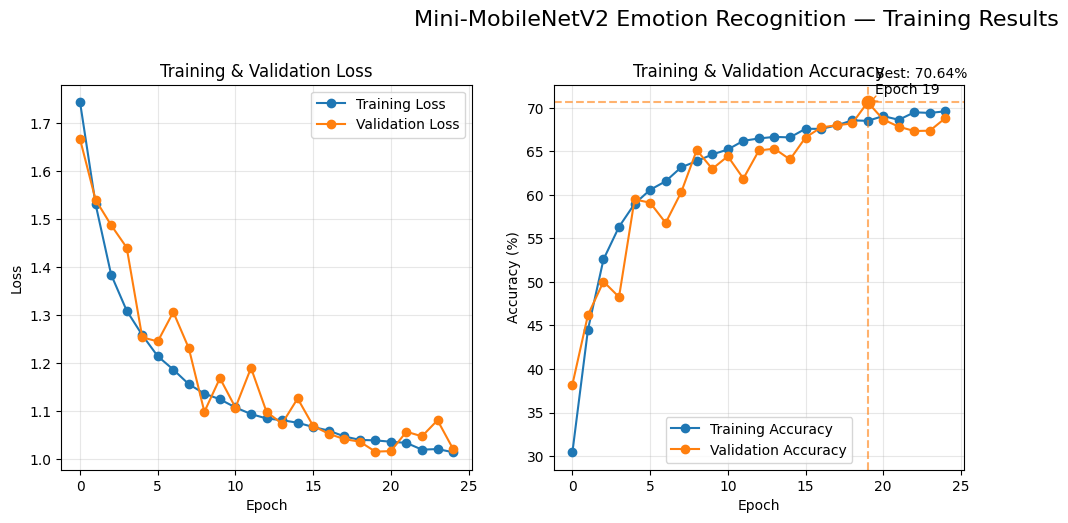

In [ ]:
hist_path = OUT_DIR / "history.csv"
assert hist_path.exists(), f"history.csv not found at {hist_path}"
hist = pd.read_csv(hist_path)

# Make sure we have an epoch column
if "epoch" not in hist.columns:
    hist["epoch"] = np.arange(1, len(hist) + 1)

# Figure out the best validation accuracy
best_idx = int(hist["val_accuracy"].idxmax())
best_epoch = int(hist.loc[best_idx, "epoch"])
best_val_acc = float(hist.loc[best_idx, "val_accuracy"]) * 100.0

# Learning rate column (robust to naming)
lr_col = None
for c in ["lr", "learning_rate", "learning-rate"]:
    if c in hist.columns:
        lr_col = c
        break
if lr_col is None:
    # Fallback: use the optimizer's initial LR as a flat line (still useful on the plot)
    try:
        lr0 = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
    except Exception:
        lr0 = 1e-3
    hist["learning_rate"] = [lr0] * len(hist)
    lr_col = "learning_rate"

# ---- Plot ----
plt.figure(figsize=(18, 5))
plt.suptitle("Mini-MobileNetV2 Emotion Recognition — Training Results", fontsize=16, y=1.03)

# 1) Loss
ax1 = plt.subplot(1, 3, 1)
ax1.plot(hist["epoch"], hist["loss"], marker="o", label="Training Loss")
ax1.plot(hist["epoch"], hist["val_loss"], marker="o", label="Validation Loss")
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.grid(True, alpha=0.3); ax1.legend()

# 2) Accuracy (mark the best)
ax2 = plt.subplot(1, 3, 2)
ax2.plot(hist["epoch"], hist["accuracy"] * 100.0, marker="o", label="Training Accuracy")
ax2.plot(hist["epoch"], hist["val_accuracy"] * 100.0, marker="o", label="Validation Accuracy")

# dashed lines at best
ax2.axhline(best_val_acc, color="tab:orange", linestyle="--", alpha=0.6)
ax2.axvline(best_epoch, color="tab:orange", linestyle="--", alpha=0.6)
ax2.scatter([best_epoch], [best_val_acc], s=80, color="tab:orange", zorder=3)
ax2.annotate(f"Best: {best_val_acc:.2f}%\nEpoch {best_epoch}",
             xy=(best_epoch, best_val_acc),
             xytext=(best_epoch + 0.5, best_val_acc + 1.0),
             arrowprops=dict(arrowstyle="->", color="tab:orange"),
             fontsize=10)

ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy (%)"); ax2.grid(True, alpha=0.3); ax2.legend()

# Save a copy
fig_path = OUT_DIR / "training_curves.png"
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
print("Saved curves to:", fig_path)
